# 0. 课程前言
此为《人工智能安全》实验课第二部分：对抗训练实验部分.

在对抗扰动攻击部分，我们学习到：对抗攻击本质是一个优化问题，即需要找到这个问题的解：
$$
\arg \max _{||\delta|| \le \epsilon} \mathcal{L} (h_\theta(x + \delta), y)
$$

在本章中，我们学习一个对对抗性攻击具有鲁棒性的模型的任务：无论对手使用什么攻击，我们都希望有一个性能良好的模型。对于一组输入/输出对S，我们需要解决外部最小化问题：
$$
\arg \min _\theta \frac{1}{|S|} \sum_{x, y \in S} \max \mathcal{L}(h_\theta(x + \delta), y)
$$
这是一个 min-max 优化问题，max在最小化内部，意味着对手试图最大化模型的训练损失，而我们需要使得这样的一个模型在对抗性样本中与原始类别的损失越小，这样即使攻击者使用到了对抗性样本，我们的模型也不会受到攻击。

# 1. 训练准备

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# 使用 MNIST 数据集进行测试
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
# 定义数据迭代器实例
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)
# 选择 device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 设置 torch 种子，实现复现性
torch.manual_seed(0)

# input 展开成一维
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

# 卷积神经网络
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [3]:
# FGSM算法，返回扰动
def fgsm(model, X, y, epsilon=0.1):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

# PGD算法，返回扰动
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [4]:
# 返回模型在干净数据集上一个 epoch 的训练/测试误差
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt: # optimizer: Training  None: Evaluation
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    # 返回误差/损失
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


# 返回模型在对抗数据集上一个 epoch 的训练/测试误差
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt: # optimizer: Training  None: Evaluation
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [7]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
print("Train Error", "Test Error", "Adv Error", sep="\t")

# 模型在 MNIST 上进行训练
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

Train Error	Test Error	Adv Error
0.015733	0.015200	0.668200
0.011717	0.015700	0.697500
0.009150	0.013700	0.675600
0.007117	0.015600	0.729200
0.006200	0.012200	0.743500
0.002333	0.010400	0.733000
0.001383	0.010100	0.734100
0.000967	0.010500	0.726300
0.000767	0.010300	0.730600
0.000683	0.010400	0.723800


In [8]:
# 定义使用对抗性训练的模型
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [9]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
print("Train Error", "Test Error", "Adv Error", sep="\t")
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

Train Error	Test Error	Adv Error
0.757683	0.071600	0.195200
0.108800	0.019300	0.063800
0.054800	0.015600	0.048700
0.040350	0.011800	0.038800
0.032900	0.011300	0.033000
0.022400	0.009300	0.030000
0.020400	0.009500	0.030400
0.020000	0.008800	0.029100
0.019150	0.008000	0.028200
0.018583	0.009100	0.028000


In [10]:
# 返回模型在不同对抗攻击算法下的误差
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])
print("PGD, small_alpha: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40, alpha=0.05)[0])
print("PGD, randomized: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, 
                                             num_iter=40, randomize=True)[0])

FGSM:  0.0266
PGD, 40 iter:  0.0284
PGD, small_alpha:  0.0282
PGD, randomized:  0.0286


In [11]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

# 绘制损失函数图像

In [12]:
def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    # 使用 add_subplot 创建 3D 坐标轴
    ax = fig.add_subplot(111, projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

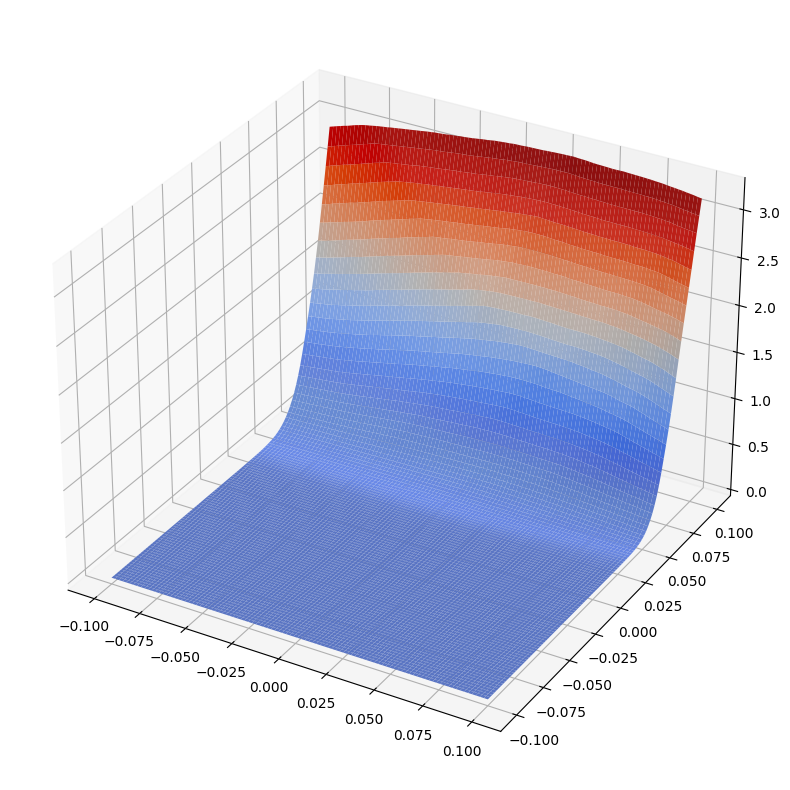

In [13]:
draw_loss(model_cnn, X[0:1], 0.1)

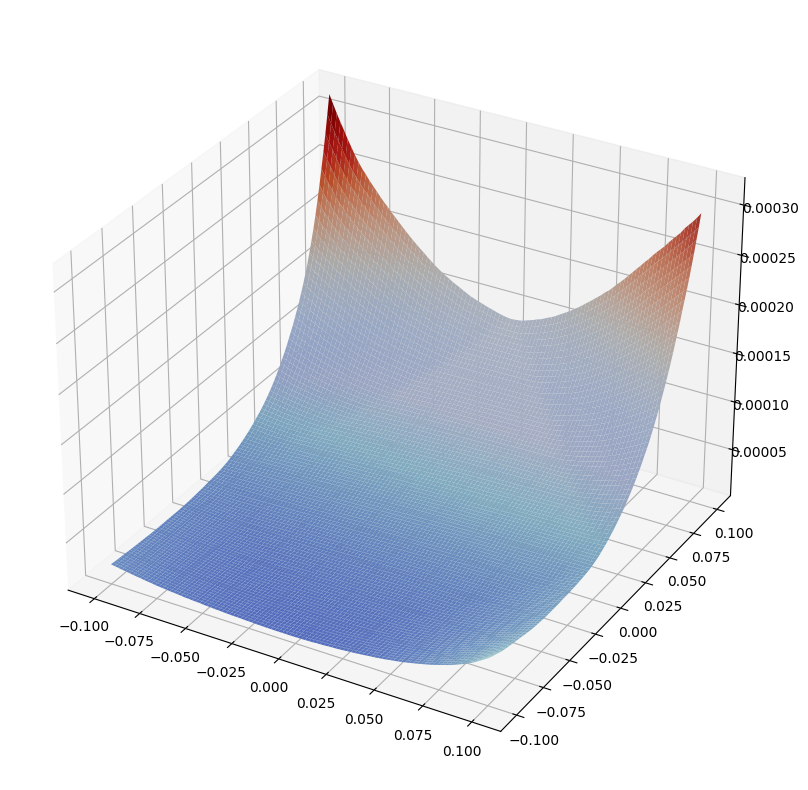

In [26]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

为了实现对 `model_cnn_robust` 鲁棒性能的量化评估，下面将借助这套测试模型鲁棒性的代码，对该模型在测试数据集上的鲁棒性展开系统性测试 。

In [22]:
'''
bound_propagation 函数:
    计算神经网络各层的输出区间边界, 遍历模型每一层, 对于不同的层类型(Flatten、nn.Linear、nn.Conv2d、nn.RELU)
    使用对应公式计算其输出的上下界, 存储在 bounds 中
'''
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

'''
interval_based_bound 函数:
    基于模型输出边界(bounds)计算神经网络模型的鲁棒性下界.
'''
def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()    

'''
epoch_robust_bound 函数:
    计算模型在一个 epoch 内的鲁棒性误差
    返回测试集上模型的鲁棒性误差比例, 即, 统计在给定 epsilon 扰动范围内, 模型在各个类别上
    不满足鲁棒性条件的样本数量占总样本数量的比例.
'''
def evaluate_epoch_robust_bound(loader, model, epsilon):
    total_err = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        for y0 in range(10):
            lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
            total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
    return total_err / len(loader.dataset)

In [23]:
evaluate_epoch_robust_bound(test_loader, model_cnn_robust, 0.1)

1.0

In [24]:
evaluate_epoch_robust_bound(test_loader, model_cnn_robust, 0.0001)

0.0203

通过对上述代码的运行与分析可得，当扰动参数 $\epsilon \in [-0.1, 0.1]$ 时，模型 `model_cnn_robust` 无法展现出鲁棒特性（几乎所有测试集样本均不满足模型鲁棒性条件）；当扰动参数 $\epsilon$ 收缩至 $[-0.0001, 0.0001]$时，模型的鲁棒性显著提升，测试集中约 $98\%$ 的样本满足鲁棒性要求。

换句话说，我们的模型在 $||\epsilon||_\infty \le 0.0001$ 时具有良好的鲁棒性。

下面，我们将借助模型鲁棒性评估的结果，对模型训练过程实施优化。在训练或评估的每个批次中，先依据输入数据和指定的扰动范围，计算模型各层输出的区间边界。
在此基础上，针对模型预测的类别，计算该类别下的鲁棒性下界，将这个下界累加到损失函数值 `loss` 中。

这样，损失函数不仅包括了常规的分类错误，还融入了模型在面对输入扰动时的鲁棒性信息，模型根据这个损失函数更新参数，从而在模型分类准确率提升的同时，
促使模型在指定扰动范围内的鲁棒性得到增强，应对输入数据可能存在的各种干扰。

In [ ]:
def epoch_robust_bound(loader, model, epsilon, opt=None):
    total_err = 0
    total_loss = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)
        loss = 0
        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                total_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        total_loss += loss.item() * X.shape[0]  
        #print(loss.item())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [18]:
torch.manual_seed(0)
model_cnn_robust_2 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2), nn.ReLU(),
                                   nn.Conv2d(32, 32, 3, padding=1, ), nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                   Flatten(),
                                   nn.Linear(7*7*64, 100), nn.ReLU(),
                                   nn.Linear(100, 10)).to(device)

In [19]:
opt = optim.SGD(model_cnn_robust_2.parameters(), lr=1e-1)
eps_schedule = [0.0, 0.0001, 0.001, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.05] + 15*[0.1]

print("Train Eps", "Train Loss*", "Test Err", "Test Robust Err", sep="\t")
for t in range(len(eps_schedule)):
    train_err, train_loss = epoch_robust_bound(train_loader, model_cnn_robust_2, eps_schedule[t], opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust_2)
    adv_err, adv_loss = epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)

    # 调参使用
    if t == 4:
       for param_group in opt.param_groups:
           param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (eps_schedule[t], train_loss, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust_2.state_dict(), "model_cnn_robust_2.pt")

Train Eps	Train Loss*	Test Err	Test Robust Err


0.000000	0.835771	0.031500	1.000000
0.000100	0.125941	0.021500	1.000000
0.001000	0.120870	0.022600	1.000000
0.010000	0.341352	0.028100	1.000000
0.010000	0.160670	0.025400	1.000000
0.050000	0.560360	0.030000	0.975400
0.050000	0.427368	0.030300	0.963600
0.050000	0.384079	0.030600	0.930500
0.050000	0.357235	0.030200	0.886300
0.050000	0.337236	0.030800	0.830700
0.100000	0.838830	0.041600	0.185400
0.100000	0.637333	0.043000	0.164000
0.100000	0.562028	0.042400	0.147400
0.100000	0.515194	0.040700	0.135600
0.100000	0.475985	0.041400	0.127500
0.100000	0.441126	0.040900	0.120200
0.100000	0.412448	0.040300	0.112500
0.100000	0.389139	0.040600	0.108200
0.100000	0.368990	0.038800	0.103100
0.100000	0.352168	0.039200	0.101400
0.100000	0.338744	0.038700	0.097300
0.100000	0.326916	0.038000	0.094100
0.100000	0.316879	0.037100	0.092000
0.100000	0.308328	0.037400	0.088800
0.100000	0.300363	0.037500	0.089300


In [20]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust_2, pgd_linf, num_iter=40)[0])

PGD, 40 iter:  0.0689


In [26]:
evaluate_epoch_robust_bound(test_loader, model_cnn_robust_2, 0.1)

0.0893